In [1]:
#| default_exp interpolation

In [2]:
#| export

import numpy as np
from skimage import transform
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
from blender_tissue_cartography import io as tcio

In [3]:
import os
import mcubes
import pymeshlab
from scipy import ndimage

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/lib/python3.9/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



## Basic example of tissue cartography workflow

In this notebook, we go through a basic example of tissue cartography - extracting the mildly curved surface of an epithelium from a confocal $z$-stack (data from (Lye et al. 2024)[https://doi.org/10.1371/journal.pbio.3002611].

We introduce the functions of our python module for cartographic interpolation one by one.

### Important conventions

1. Image axis 0 is always the channel. All other axes are not permuted
2. Mesh coordinates are always in microns. Mesh coordinates are always positive, since they are derived from pixel coordinates, 
3. In saved `.tif` files, `-1` represents missing data/NaN.
4. The UV map target domain is always the unit square, $u\in[0,1], \; v\in[0,1]$

## Load and subsample data for segmentation

**Data description** myosin + membrane ventral view of Drosophila embryo during germband extension, from Lye et al. 2024.

We begin by creating a directory for our project where we'll save all related files (and normally, the jupyter notebook used to generate them!).

Let's load the dataset. We then enter the relevant metadata - the filename, resolution in microns, and how much we want to subsample for segmentation purposes.

In [4]:
metadata_dict = {'filename': 'basics_example/basics_example',
                 'resolution_in_microns': (1, 0.36, 0.36), # you can typically get this from the .tif metadata
                 'subsampling_factors': (1, 1/3, 1/3)}

In [5]:
metadata_dict['subsampling_factors']

(1, 0.3333333333333333, 0.3333333333333333)

In [6]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (2, 26, 454, 511)


In [7]:
subsampled_image = transform.rescale(image, metadata_dict['subsampling_factors'],
                                     channel_axis=0, preserve_range=True)
print("subsampled image shape:", subsampled_image.shape)

subsampled image shape: (2, 26, 151, 170)


## Create 3d segmentation

Now create a 3d segmentation, in this case using ilatik. We use [ilastik binary pixel classification](https://www.ilastik.org/documentation/pixelclassification/pixelclassification). We could post-process the ilastik output here, for example using morphsnakes. We then load the segmentation back into the jupyter notebook.

Attention: when importing the `.h5` into ilastik, make sure the dimension order is correct! In this case, `czyx` for both export and import.

In [8]:
# we now save the subsampled image a .h5 file for input into ilastik for segmentation

tcio.write_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image)

In [9]:
# after creating an ilastik project, training the model, and exporting the probabilities, we load the segmentation

segmentation = tcio.read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # select the first channel of the segmentation - it's the probablity a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (26, 151, 170)


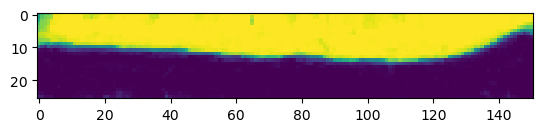

In [10]:
# look at the segmentation in a cross section

plt.imshow(segmentation[:,:,50], vmin=0, vmax=1)

## Meshing

We convert the segmentation into a triangular mesh using the marching cubes method, and save the mesh. We save all meshes in as wavefront `.obj` files (see [wikipedia](https://en.wikipedia.org/wiki/Wavefront_.obj_file)). In python, we represent missing entries (such as a vertex which doesn't have a normal by `np.nan`.

**Important convention** For sanities sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

In [11]:
# now we create a 3d mesh of using the marching cubes method

level_set = mcubes.smooth(segmentation, method="gaussian") # converts segmentation into level set, with 0=surface
vertices, faces = mcubes.marching_cubes(level_set, 0)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

mesh = tcio.ObjMesh(vertices_in_microns, faces)
mesh.name = "basics_example_mesh_marching_cubes"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

### Optional - improve mesh quality using MeshLab

We can remesh the output of the marching cubes algorithm to obtain an improved mesh, i.e. with more uniform triangle shapes. In this example, we first remesh to make the mesh more uniform.
You can also try this out in the MeshLab GUI and export your workflow as a python script. Be careful not to move the mesh or it will mess up the correspondence with the pixel coordinates!

See [List of MeshLab filers](https://pymeshlab.readthedocs.io/en/latest/filter_list.html)

In [12]:
ms = pymeshlab.MeshSet()
ms.load_new_mesh(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")
ms.meshing_isotropic_explicit_remeshing()
ms.save_current_mesh(f"{metadata_dict['filename']}_mesh_remeshed.obj")

To check all went well, let's overlay the mesh coordinates over a cross section of the image. To do so, we first select the vertices whose positions correspond to the image slice, and then correctly rescale coordinates from microns to pixel coordinates.

In [53]:
#| export

def get_cross_section_vertices_normals(slice_axis, slice_index, image, mesh, resolution,
                                       get_normals=True, width=3):
    """
    Get mesh vertices and normals for diagnostic cross-section overlay plot.
    
    Usage example:
        slice_image, slice_vertices, slice_normals = get_cross_section_vertices_normals(1, 100,
                                    image, mesh, metadata_dict["resolution_in_microns"])
        plt.scatter(*slice_vertices.T, s=5, c="tab:red")
        plt.quiver(*slice_vertices.T, *slice_normals.T, color="tab:red")
        plt.imshow(slice_image[0], vmax=10000, origin="lower")
    
    Note: origin="lower" in plt.imshow() is essential!! 
    
    Parameters
    ----------
    image : 4d np.ndarray of shape (channels, n_x, n_y, n_z)
        Image. Axis 0 is channel
    mesh : tcio.ObjMesh
        Mesh
    resolution : int, default 256
        Resolution in pixels/micron.
    slice_index : int
        Index along sliced axis
    slice_axis : int, 0,1,2
        Axis along which to slice image array
    get_normals : bool, default True
        Whether to return normals also
    width : float
        Width of slice for vertex selection, in micron
    
    Returns
    -------
    slice_image : 3d np.array 
        Slice of image. Axis 0 is channel
    slice_vertices : 2d  np.array
        Projected vertices in slice. Second axis is the coordinate one.
    slice_normals : 2d  np.array (..., 2)
        Projected normals in slice. Second axis is the coordinate one.

    """
    slice_image = image.take(indices=slice_index, axis=slice_axis+1).transpose((0,2,1))
    slice_coordinate = slize_index*resolution[slice_axis]
    if get_normals:
        mesh.match_vertex_info()
        slice_mask = np.abs(mesh.matched_vertices[:,slice_axis]-slice_coordinate) < width
        slice_vertices = mesh.matched_vertices[slice_mask] / resolution
        slice_vertices = slice_vertices.take(indices=[i for i in range(3) if i != slice_axis], axis=1)
        slice_normals = mesh.matched_normals[slice_mask] / resolution
        slice_normals = slice_normals.take(indices=[i for i in range(3) if i != slice_axis], axis=1)
        return slice_image, slice_vertices, slice_normals
    slice_mask = np.abs(mesh.vertices[:,slice_axis]-slice_coordinate) < width
    slice_vertices = mesh.vertices[slice_mask] / resolution
    slice_vertices = slice_vertices.take(indices=[i for i in range(3) if i != slice_axis], axis=1)
    return slice_image, slice_vertices

In [54]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
mesh = tcio.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")

In [57]:
slice_image, slice_vertices = get_cross_section_vertices_normals(2, 200,
                                image, mesh, metadata_dict["resolution_in_microns"], get_normals=False)

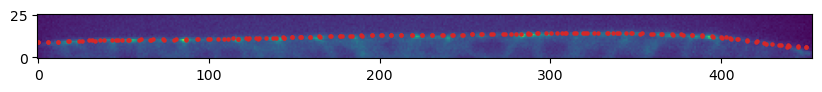

In [60]:
fig = plt.figure(figsize=(10,10))
plt.scatter(*slice_vertices[:,::-1].T, s=5, c="tab:red")
plt.imshow(slice_image[0].T, origin="lower")

## UV-mapping in blender

We now switch to blender and create a new empty project, which we will call `f"{metadata_dict['filename']}.blend"`. We import the mesh just generated (File->Import).

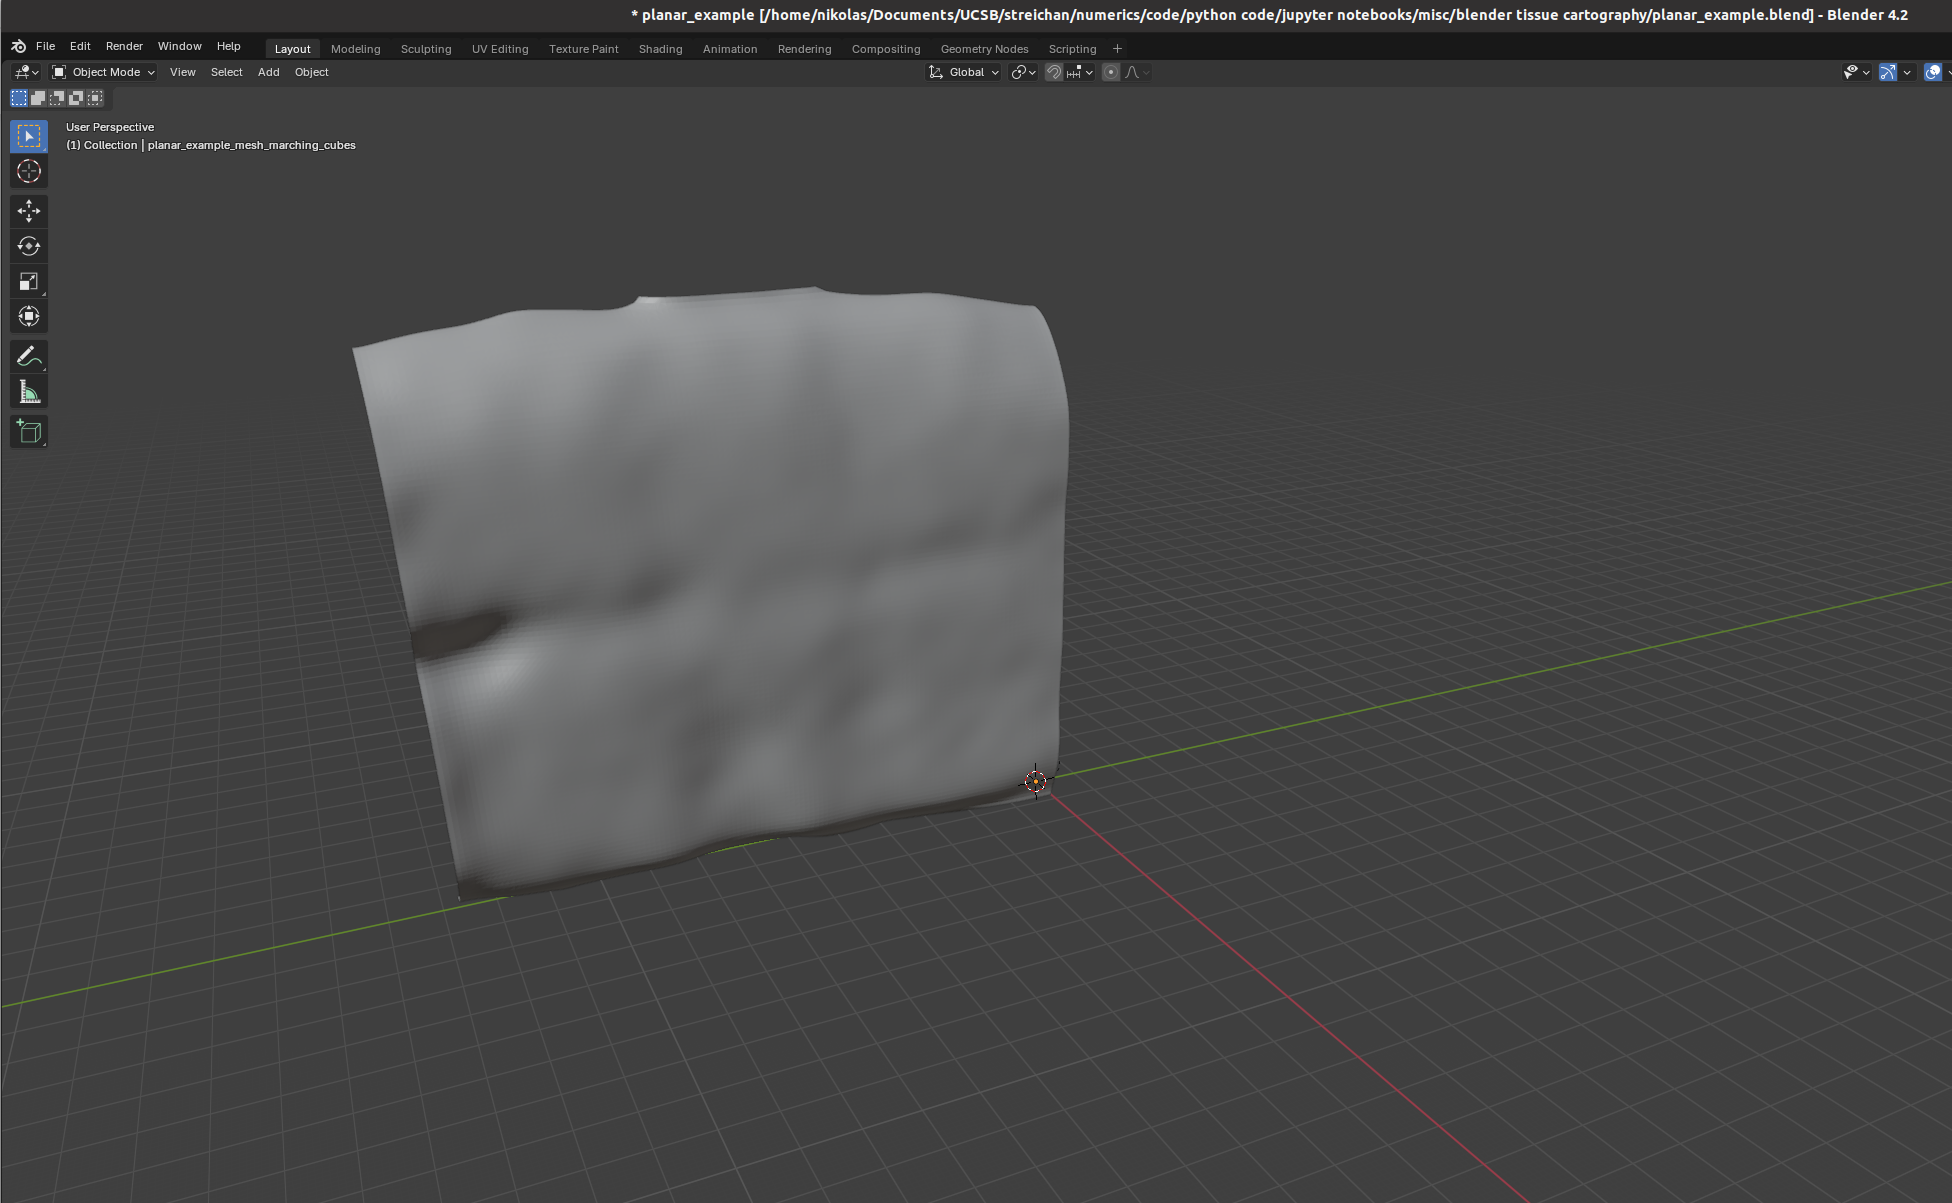

I recommend using the "object" tab (orange square on right toolbar) to lock mesh position and rotation so we don't accidentally move it.

To 3d-render the underlying data, we can use the [MicroscopyNodes](https://github.com/oanegros/MicroscopyNodes) plugin. Go to the right hand panel:

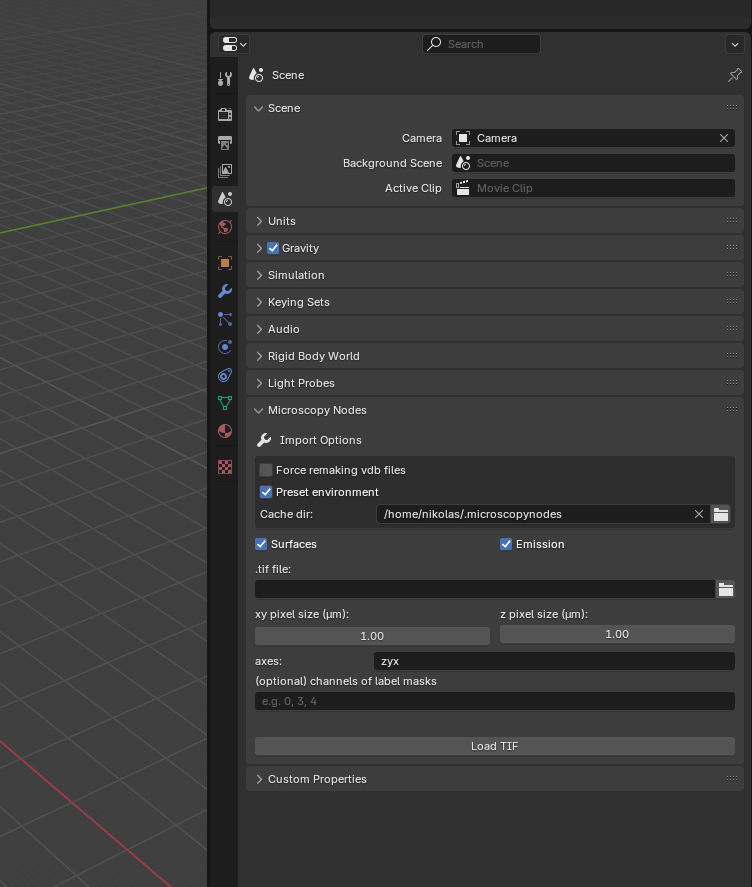

So far this does not yet work as intended - MicroscopyNodes rescales coordinates in such a way that they do mot overlap with the mesh. Fixing this should be a simple matter of translating and rescaling the objects created by MicroscopyNodes. **To do**: need to figure out what scaling factor the plugin uses. This is what the MicroscopyNodes developer says:

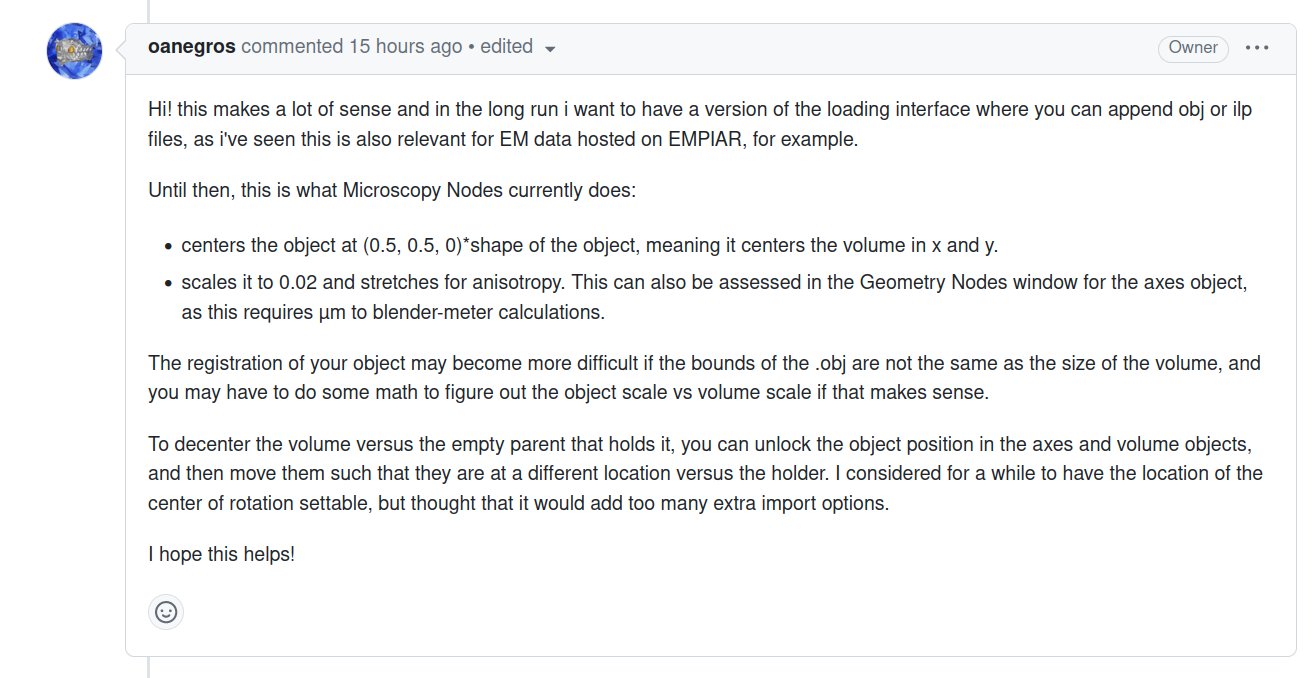

Let's try to move forward and get a UV map of the mesh. To do so, we go to the "UV Editing" tab on the top toolbar, press "3" then "A" to select all faces ("1" selects vertices, "2" edges, and "3" faces). Click "UV->unwrap" on the top panel.
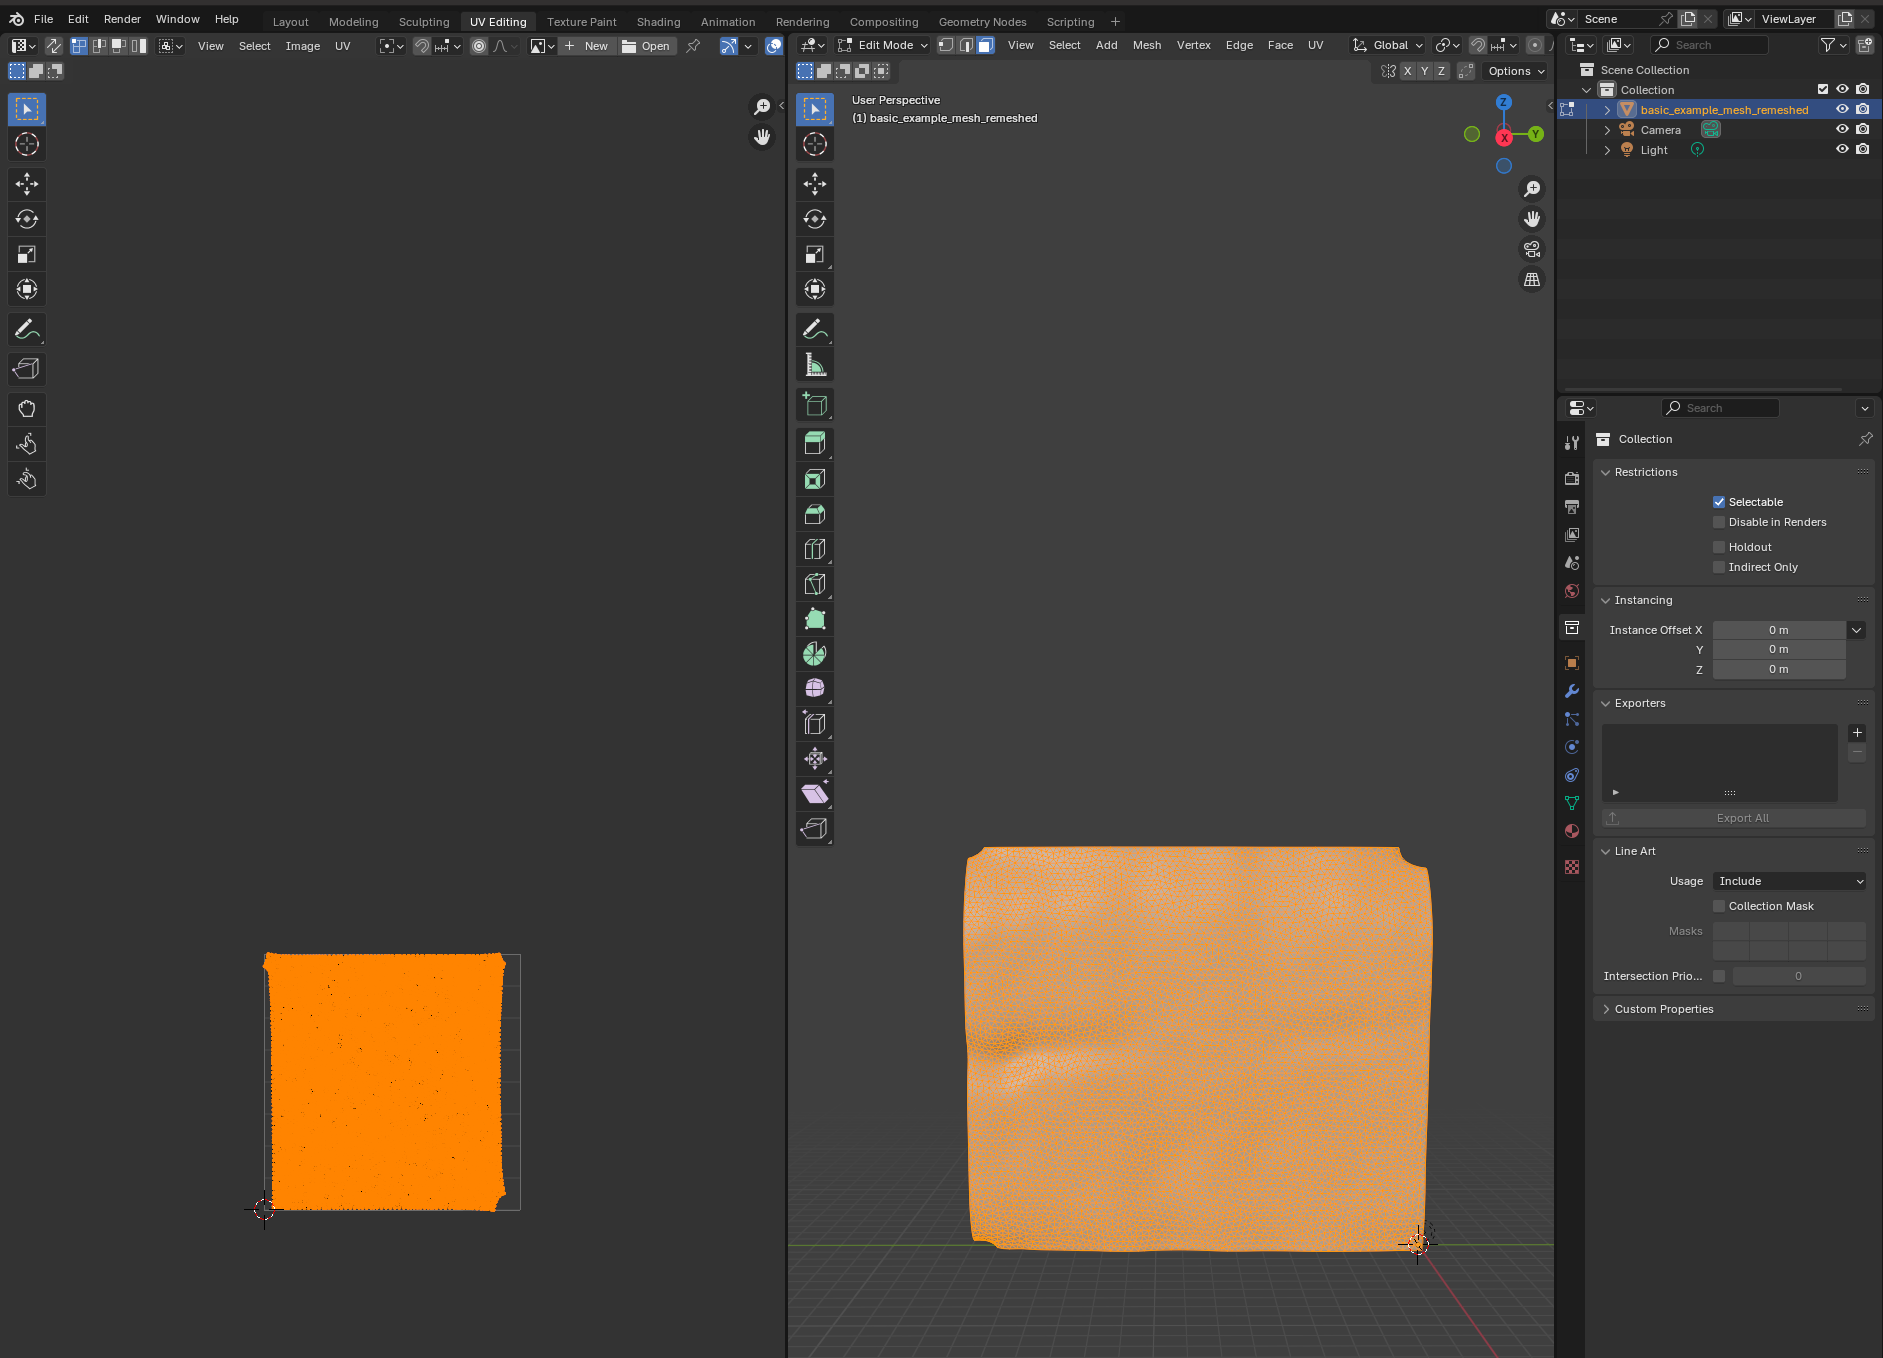
For more complicated meshes (e.g. a sphere), we will need to use extra steps, e.g. define seams.

We then click on export and save as `.obj` with UV and normals. The new mesh file `f"{metadata_dict['filename']}_mesh_uv.obj"` now contains vertex normals and UV coordinates as `vn` and `vt` lines. Note - there can be more `vt`'s than `v`'s.

### Interpolation onto UV grid

We now read in the new `.obj` file in order to interpolate the image data onto the 3d mesh. We first introduce the functions necessary to do so, which are based on the `scipy.interpolation` module. Interpolation proceeds in two steps:
1. Interpolate the 3d coordinates from the mesh UV vertex positions onto the whole UV grid
2. Evaluate the image signal at the UV gridded 3d coordinates using a second interpolation step.
This ensures that the resolution of the cartographic projection is not limited by the resolution of the mesh.

The UV grid always covers the unit square $[0,1]^2$.

We first show how the interpolation works in a step-by-step manner, and the give a function that packages the whole process.

In [14]:
# let's read in the mesh and match up the vertices, texture vertices and normal vectors using the
# mesh connectivity information
mesh = tcio.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_uv.obj")
mesh.match_vertex_info()

# let's also load the image
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))

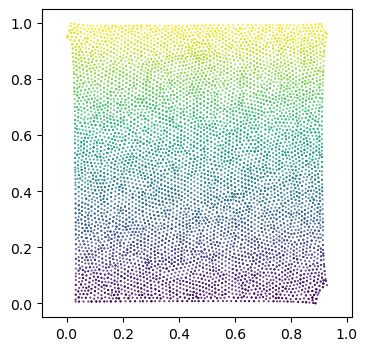

In [16]:
# let's make a scatter plot of the mesh texture coordinates, and color it by 3d coordinate x

fig = plt.figure(figsize=(4,4),)
plt.scatter(*mesh.matched_texture_vertices.T, s=0.2, c=mesh.matched_vertices[:,2])
plt.axis("equal");

It's not very noticeable in this example, but the part of the UV square covered by the unwrapped mesh can be extremely non-convex, in particular if there are multiple patches (see notebook 3). Here is an example:
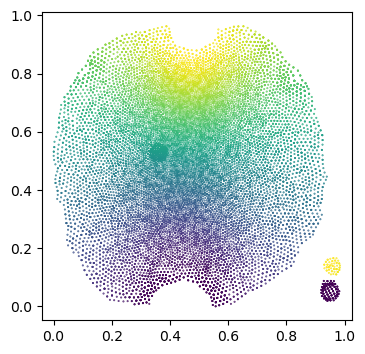

By default, interpolation will give us results in the entire convex hull of the texture coordinates in the UV square, which we don't want. Therefore, we generate a UV layout mask which delineates the part of the UV square covered by the unwrapped mesh. Here, we do this using a `matplotlib` hack, but we can also export the UV layout as a `.png` from blender, and read it in as a mask in the "UV editing" tab:

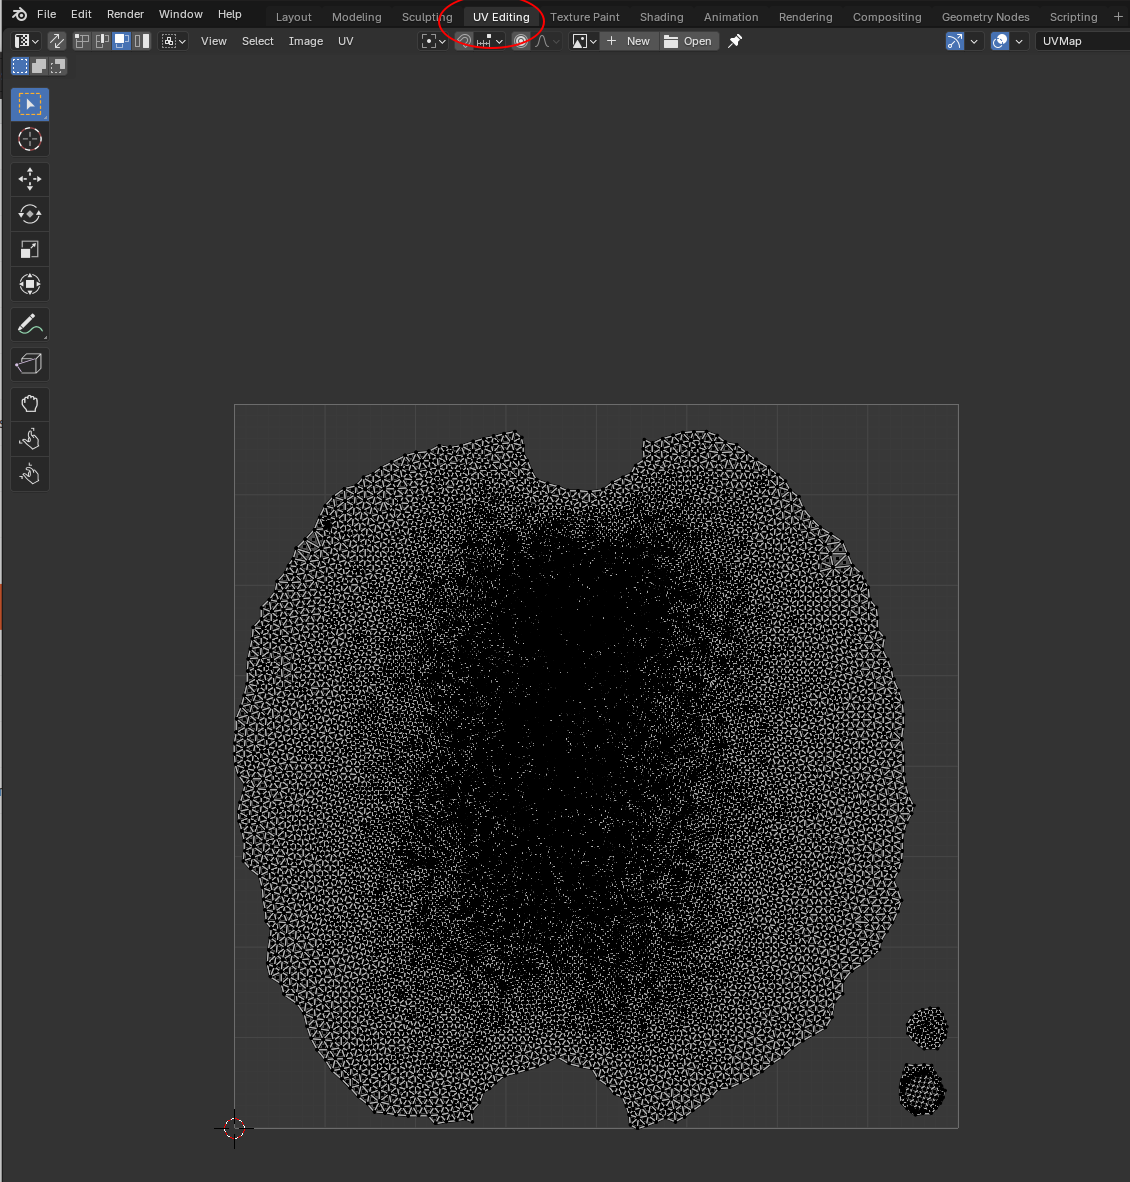

In [17]:
#| export

def get_uv_layout_mask_mask(mesh, uv_grid_steps=256):
    """
    Get a layout mask of the UV square: 1 where the UV square is covered by the unwrapped mesh, 0 outside.
    
    Based on a questionable matplotlib hack.
    
    Parameters
    ----------
    mesh : tcio.ObjMesh
        Mesh with texture_vertices
    uv_grid_steps : int, default 256
        Size of UV grid. Determines resolution of result.
    
    Returns
    -------
    uv_mask : np.array of shape (uv_grid_steps, uv_grid_steps)
        Mask of the part of the UV square covered by the unwrapped mesh
    """
    assert mesh.texture_vertices is not None, "mesh must have texture vertices"
    valid_faces = [[v[1] for v in fc] for fc in mesh.faces if not np.isnan(list(tcio.flatten(fc))).any()]
    polygons = mpl.collections.PatchCollection([mpl.patches.Polygon([mesh.texture_vertices[v] for v in fc])
                                                for fc in valid_faces], color="black")
    fig = plt.figure(figsize=(1,1), dpi=uv_grid_steps, frameon=False)
    ax = plt.gca()
    ax.add_collection(polygons)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    fig.canvas.draw()
    uv_mask = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).astype(float)
    uv_mask = 1-(uv_mask.reshape(fig.canvas.get_width_height()[::-1] + (4,))[...,0] > 0)
    plt.close()
    
    return uv_mask.astype(bool)

In [18]:
# let's see this function in action

In [19]:
uv_mask = get_uv_layout_mask_mask(mesh, uv_grid_steps=256)

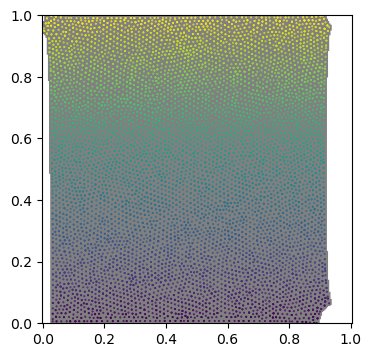

In [21]:
fig = plt.figure(figsize=(4,4),)
plt.imshow(uv_mask, cmap='Grays', alpha=0.5, extent=(0,1,0,1))
plt.scatter(*mesh.matched_texture_vertices.T, s=0.2, c=mesh.matched_vertices[:,2])
plt.axis("equal");

### UV interpolation

In [22]:
#| export

def interpolate_3d_to_uv(matched_texture_vertices, matched_vertices_or_normals, uv_mask=None, uv_grid_steps=256):
    """
    Interpolate 3d mesh coordinates or mesh normals onto UV square.
    
    Assumes the map $x,y,z \mapsto u,v$ to be invertible. This is not guaranteed - you can create overlapping UV 
    coordinates in blender. 
    
    Parameters
    ----------
    matched_vertices_or_normals : np.array of shape (n_matched, 3)
        Vertex 3d coordinates or normals, matched to UV coordinates
    matched_texture_vertices : np.array of shape (n_matched, 2)
        Matched texture vertices. Will be mapped back to [0, 1]^2!
    uv_mask : None or np.array of shape (uv_grid_steps, uv_grid_steps) of dtype bool
        Mask of covered part of the UV square. If provided, interpolation results are set to np.nan outside the
        covered region. If None, no masking takes place. No masking may result in spurious results
        in the part of the UV square not covered by the unwrapped mesh.
    uv_grid_steps : int, default 256
        Size of UV grid. Determines resolution of result.

    Returns
    -------
    interpolated_3d : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d positions or normals across [0,1]^2 UV grid, with uniform step size. UV positions that don't
        correspond to any value are set to np.nan.
        
    """
    matched_texture_vertices %= 1
    u, v = 2*[np.linspace(0,1, uv_grid_steps),]
    U, V = np.meshgrid(u, v)
    interpolated_3d = np.stack([interpolate.griddata(matched_texture_vertices, x, (U, V), method='linear')
                                for x in matched_vertices_or_normals.T], axis=-1)
    interpolated_3d = interpolated_3d[::-1] # stupid axis convention issue!!
    if uv_mask is not None:
        interpolated_3d[~uv_mask,:] = np.nan
    return interpolated_3d

In [23]:
#| export

def interpolate_volumetric_data_to_uv(image, interpolated_3d_positions, resolution, uv_mask=None):
    """ 
    Interpolate volumetric image data onto UV coordinate grid.
    
    Uses 3d positions corresponding to each UV grid point as computed by interpolate_3d_to_uv.
    3d coordinates (in microns) are converted into image coordinates via the scaling factor.
    
    Parameters
    ----------
    image : 4d np.array
        Image, axis 0  is assumed to be the channel axis
    interpolated_3d_positions : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d positions across [0,1]^2 UV grid, with uniform step size. UV positions that don't correspond to 
        any value are set to np.nan.
    resolution : np.array of shape (3,)
        Resolution in pixels/microns for each of the three spatial axes.
    uv_mask : None or np.array of shape (uv_grid_steps, uv_grid_steps) of dtype bool
        Mask of covered part of the UV square. If provided, interpolation results are set to np.nan outside the
        covered region. If None, no masking takes place. No masking may result in spurious results
        in the part of the UV square not covered by the unwrapped mesh.

    
    Returns
    -------
    interpolated_data : np.array of shape (n_channels, uv_grid_steps, uv_grid_steps)
        3d volumetric data interpolated onto UV grid.
    
    """
    x, y, z = [np.arange(ni) for ni in image.shape[1:]]
    interpolated_data = np.stack([interpolate.interpn((x, y, z), channel, interpolated_3d_positions/resolution,
                                  method="linear", bounds_error=False) for channel in image])
    if uv_mask is not None:
        interpolated_data[:,~uv_mask] = np.nan
    
    return interpolated_data

In [24]:
# first interpolation step 

uv_grid_steps = 256  # set UV grid size
uv_mask = ndimage.binary_erosion(get_uv_layout_mask_mask(mesh, uv_grid_steps=uv_grid_steps), iterations=3)

# this is our UV grid
u, v = 2*[np.linspace(0,1, uv_grid_steps),]
U, V = np.meshgrid(u, v)

interpolated_3d_positions = interpolate_3d_to_uv(mesh.matched_texture_vertices,
                                                 mesh.matched_vertices,
                                                 uv_grid_steps=uv_grid_steps,
                                                 uv_mask = uv_mask)
interpolated_normals = interpolate_3d_to_uv(mesh.matched_texture_vertices,
                                            mesh.matched_normals,
                                            uv_grid_steps=uv_grid_steps,
                                            uv_mask = uv_mask)

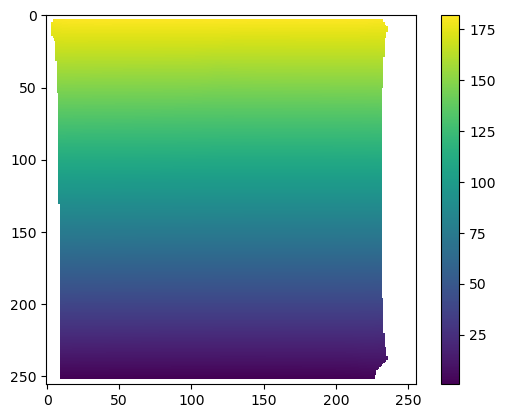

In [25]:
# let's plot the interpolated 3d coordinates
plt.imshow(interpolated_3d_positions[:,:,2])
plt.colorbar()

In [26]:
#| export

def interpolate_volumetric_data_to_uv_multilayer(image, interpolated_3d_positions, interpolated_normals,
                                                 normal_offsets, resolution, uv_mask=None):
    """ 
    Multilayer-interpolate volumetric image data onto UV coordinate grid.
    
    Uses 3d positions corresponding to each UV grid point as computed by interpolate_3d_to_uv.
    3d coordinates (in microns) are converted into image coordinates via the scaling factor.
    
    Generates multiple "layers" by shifting surface along its normals.
    
    Parameters
    ----------
    image : 4d np.array
        Image, axis 0  is assumed to be the channel axis
    interpolated_3d_positions : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d positions across [0,1]^2 UV grid, with uniform step size. UV positions that don't correspond to 
        any value are set to np.nan.
    interpolated_normals : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d normals across [0,1]^2 UV grid, with uniform step size. UV positions that don't correspond to 
        any value are set to np.nan. Normal vectors will be automatically normalized.
    normal_offsets : np.array of shape (n_layers,)
        Offsets along normal direction, in same units as interpolated_3d_positions (i.e. microns).
        0 corresponds to no shift.
    resolution : np.array of shape (3,)
        Resolution in pixels/microns for each of the three spatial axes.
    uv_mask : None or np.array of shape (uv_grid_steps, uv_grid_steps) of dtype bool
        Mask of covered part of the UV square. If provided, interpolation results are set to np.nan outside the
        covered region. If None, no masking takes place. No masking may result in spurious results
        in the part of the UV square not covered by the unwrapped mesh.
    
    Returns
    -------
    interpolated_data : np.array of shape (n_channels, n_layers, uv_grid_steps, uv_grid_steps)
        3d volumetric data multulayer-interpolated onto UV grid.
    
    """
    interpolated_normals = (interpolated_normals.T / np.linalg.norm(interpolated_normals, axis=-1).T).T
    interpolated_data = np.stack([interpolate_volumetric_data_to_uv(image,
                                  interpolated_3d_positions+o*interpolated_normals, resolution, uv_mask=uv_mask)
                                  for o in normal_offsets], axis=1)
    return interpolated_data

In [27]:
# second interpolation step. here we have to include the conversion factor from microns back to pixels

interpolated_data = interpolate_volumetric_data_to_uv(image, interpolated_3d_positions,
                                                      metadata_dict['resolution_in_microns'], uv_mask=uv_mask)

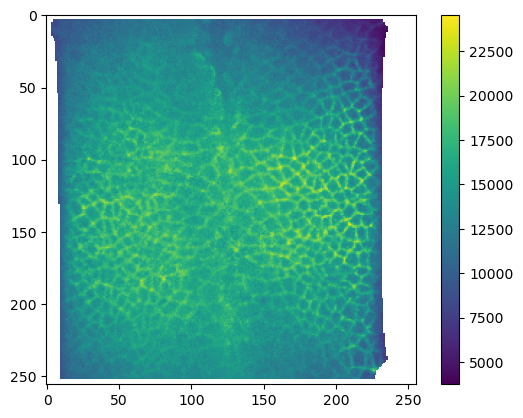

In [28]:
plt.imshow(interpolated_data[1])
plt.colorbar()

In [29]:
# now we can create a multilayer projection by  shifting the surface according to the vertex normals

normal_offsets = np.linspace(-2, 2, 5) # offset in microns

interpolated_data_multilayer = interpolate_volumetric_data_to_uv_multilayer(image,
                                                                 interpolated_3d_positions,
                                                                 interpolated_normals,
                                                                 normal_offsets,
                                                                 metadata_dict['resolution_in_microns'],
                                                                 uv_mask=uv_mask)
print("Shape: axis 0 is channel, axis 1 is normal offset", interpolated_data_multilayer.shape)

Shape: axis 0 is channel, axis 1 is normal offset (2, 5, 256, 256)


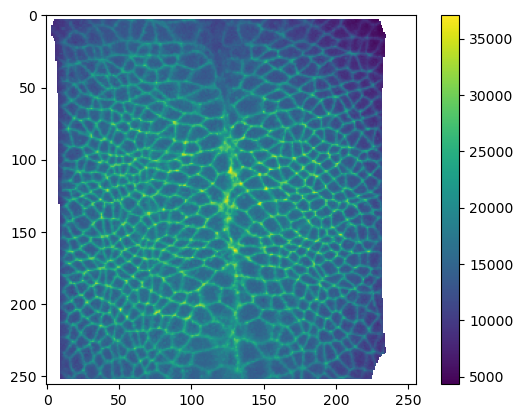

In [30]:
plt.imshow(interpolated_data_multilayer[1, 0])
plt.colorbar()

#### Packaging it up

Let's package the interpolation workflow up into a single function.

In [31]:
#| export

def create_cartographic_projections(image, mesh, resolution, normal_offsets=(0,), uv_grid_steps=256,
                                    uv_mask='auto'):
    """
    Create multilayer cartographic projections of image using mesh.
    
    Computes multiple layers along surface normal, with given normal offset (in microns). 0 offset
    corresponds to no shift away from the mesh. Also computes 3d positions (in microns)
    and surface normals interpolated onto the UV grid.
    
    UV positions that don't correspond to any 3d position are set to np.nan.
    
    Parameters
    ----------
    image : str or 4d np.array
        Image, either as path to file, or as array. If array, axis 0  is assumed to be the channel axis
    mesh : str or tcio.ObjMesh
        Mesh, either as path to file, or as ObjMesh object.
    resolution : np.array of shape (3,)
        Image resolution in pixels/micron for the three spatial axes
    normal_offsets : np.array of float, optional
        Offsets along normal direction, in same units as interpolated_3d_positions (i.e. microns).
        0 corresponds to no shift.
    uv_grid_steps : int, default 256
        Size of UV grid. Determines resolution of result.
    uv_mask : str, None, or np.array of shape (uv_grid_steps, uv_grid_steps) and dtype bool
        Mask of covered part of the UV square. Interpolation results are set to np.nan outside the
        covered region. If "auto", mask is infered automatically from the mesh information.
        If None, no masking takes place. No masking may result in spurious results in the part of
        the UV square not covered by the unwrapped mesh. Can be obtained manually from exported
        blender UV layout.
    
    Returns
    -------
    interpolated_data : np.array of shape (n_channels, n_layers, uv_grid_steps, uv_grid_steps)
        3d volumetric data multulayer-interpolated across [0,1]^2 UV grid, with uniform step size.
    interpolated_3d_positions : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d positions across [0,1]^2 UV grid, with uniform step size. 
    interpolated_normals : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        Normals across [0,1]^2 UV grid, with uniform step size.
    """
    if isinstance(image, str):
        image = tcio.adjust_axis_order(tcio.imread(image))
    if isinstance(mesh, str):
        mesh = tcio.ObjMesh.read_obj(mesh)
    if uv_mask == "auto":
        uv_mask = get_uv_layout_mask_mask(mesh, uv_grid_steps=uv_grid_steps)
    mesh.match_vertex_info()
    u, v = 2*[np.linspace(0,1, uv_grid_steps),]
    U, V = np.meshgrid(u, v)
    interpolated_3d_positions = interpolate_3d_to_uv(mesh.matched_texture_vertices,
                                                     mesh.matched_vertices,
                                                     uv_grid_steps=uv_grid_steps, uv_mask=uv_mask)
    interpolated_normals = interpolate_3d_to_uv(mesh.matched_texture_vertices,
                                                mesh.matched_normals,
                                                uv_grid_steps=uv_grid_steps, uv_mask=uv_mask)
    interpolated_data = interpolate_volumetric_data_to_uv_multilayer(image,
                                                                     interpolated_3d_positions,
                                                                     interpolated_normals,
                                                                     normal_offsets,
                                                                     resolution,
                                                                     uv_mask=uv_mask)
    return interpolated_data, interpolated_3d_positions, interpolated_normals 

In [32]:
normal_offsets = np.linspace(-2, 2, 5) # in microns

In [33]:
projected_data, projected_coordinates, projected_normals = create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"{metadata_dict['filename']}_mesh_uv.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=256)

In [34]:
# let's add the normal offset we want to our metadata - it will be important for analysis!
metadata_dict["normal_offsets"] = normal_offsets

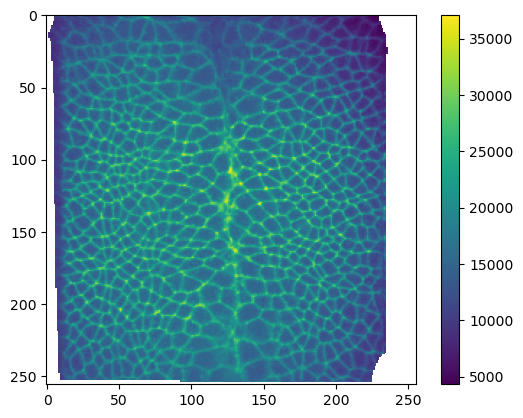

In [35]:
plt.imshow(projected_data[1, 0])
plt.colorbar()

### Saving the results

We can now save the cartographic projections both as `.tif` stack for quantitative analysis, and as `.png`'s for visualization as mesh texture in blender. We will also save the metadata to a `.json` file

Annoyingly, we have to normalize our data and convert it to 8-bit to save it as png.

In [ ]:
# save metadata
tcio.save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [ ]:
tcio.save_for_imageJ(f"{metadata_dict['filename']}_projected.tif", projected_data, z_axis=1)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_3d_coordinates.tif", projected_coordinates)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_normals.tif", projected_normals)

In [ ]:
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures"
tcio.save_stack_for_blender(projected_data, texture_path, normalization=(0.01, 0.99))

NameError: name 'os' is not defined

In [ ]:
# let's make a max projection of each channel and save them also

max_projected_ch_0, max_projected_ch_1 = projected_data.max(axis=1)
tcio.imsave(f'{texture_path}/max_channel_0.png', tcio.normalize_quantiles_for_png(max_projected_ch_0))
tcio.imsave(f'{texture_path}/max_channel_1.png', tcio.normalize_quantiles_for_png(max_projected_ch_1))

### Visualization in blender


You can set up textures in the "shading" tab:

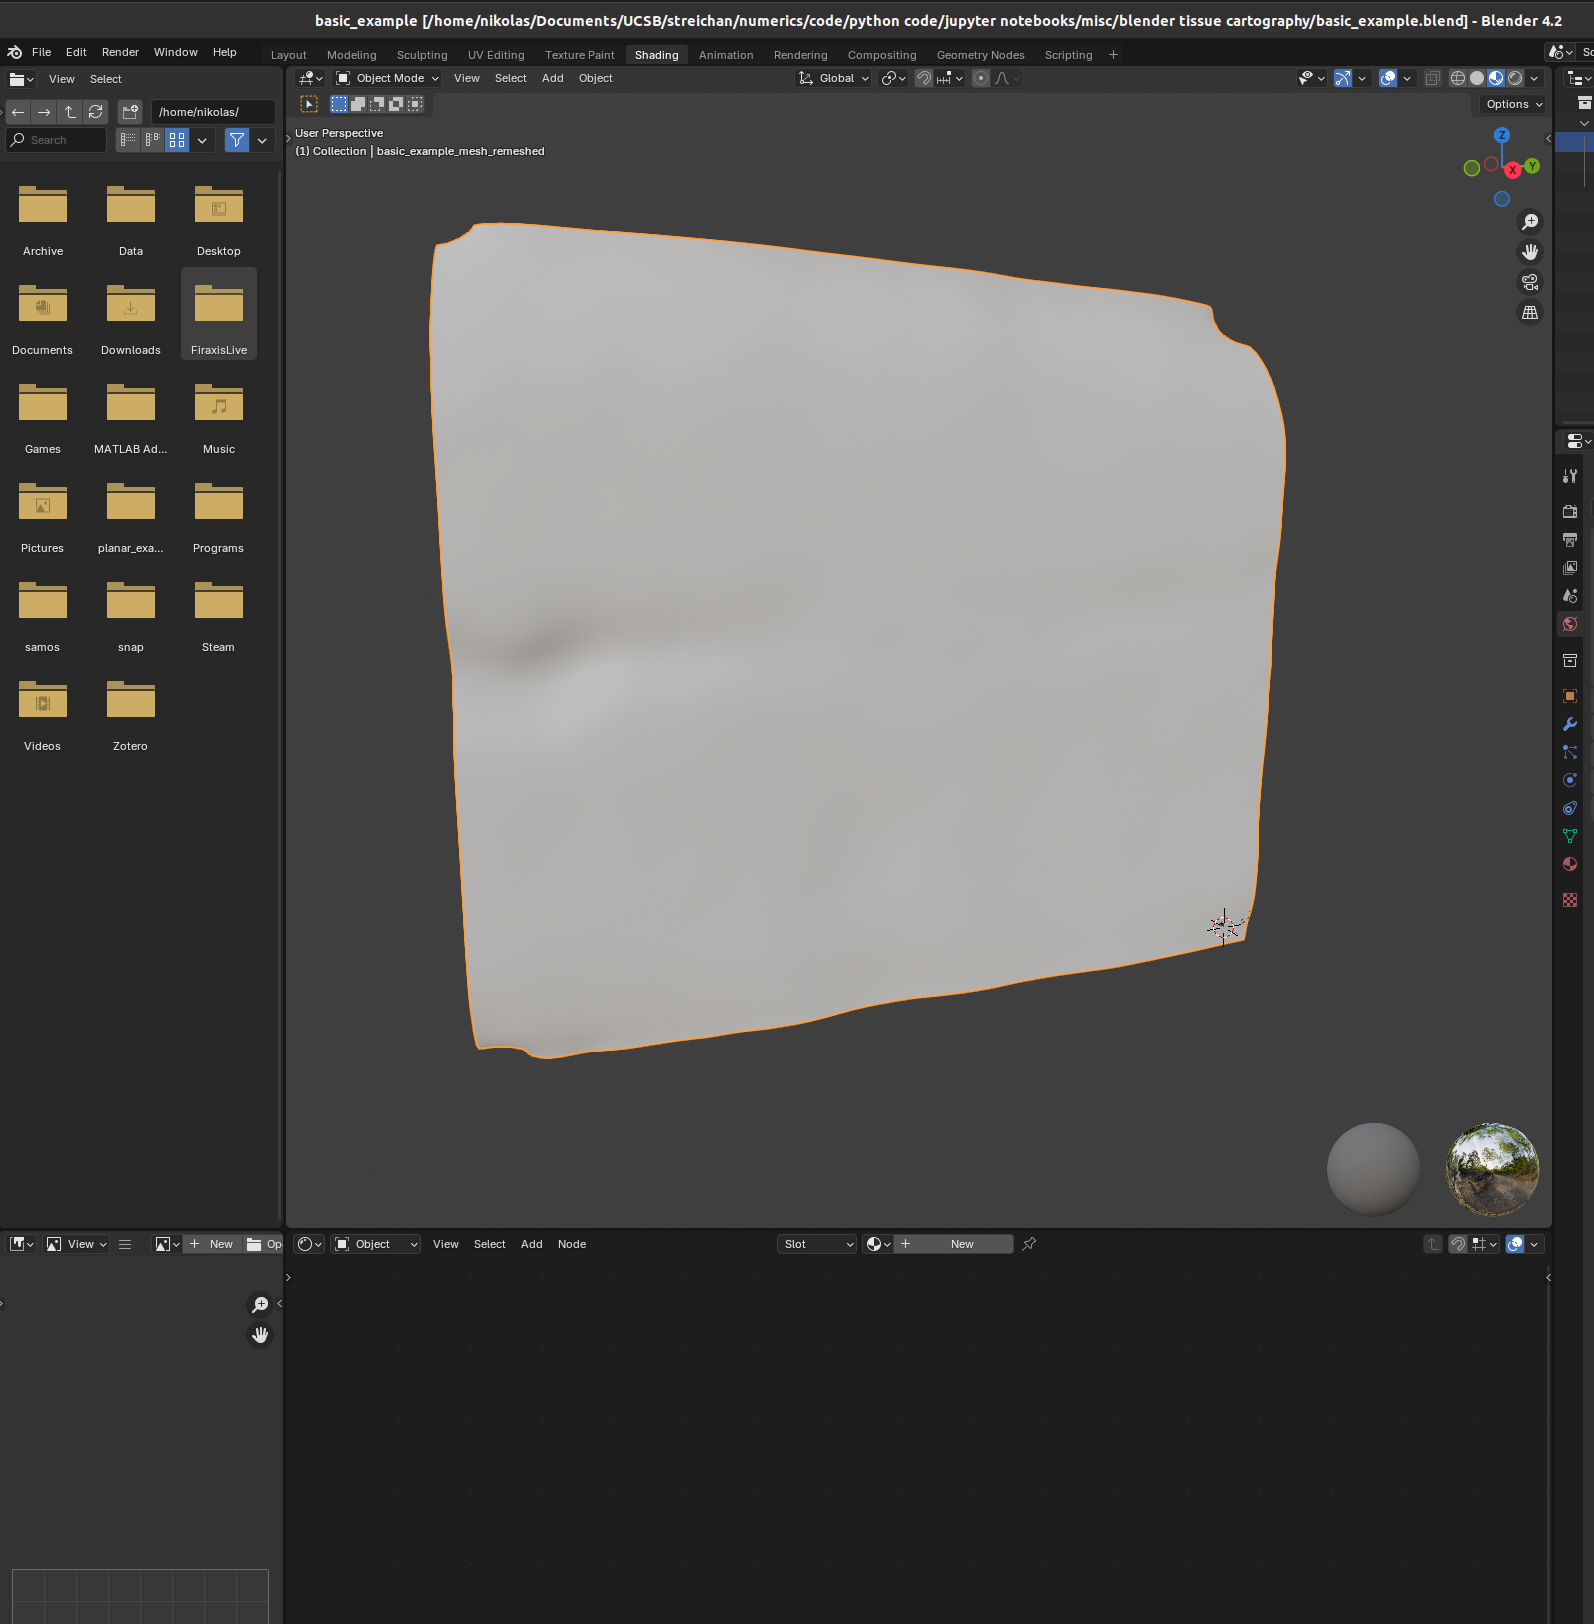

I find it helpful to remove the distracting "world" background, which you can do by either enabling "scene world" or setting "world opacity" to 0 in the viewport shading settings (arrow above "options" in top right corner)

Go to the bottom panel, add a new material (center top of bottom panel), and press "shift+A" to add a new shader element (the search bar is very helpful). Here is an example configuration mixing two channels as red and green:

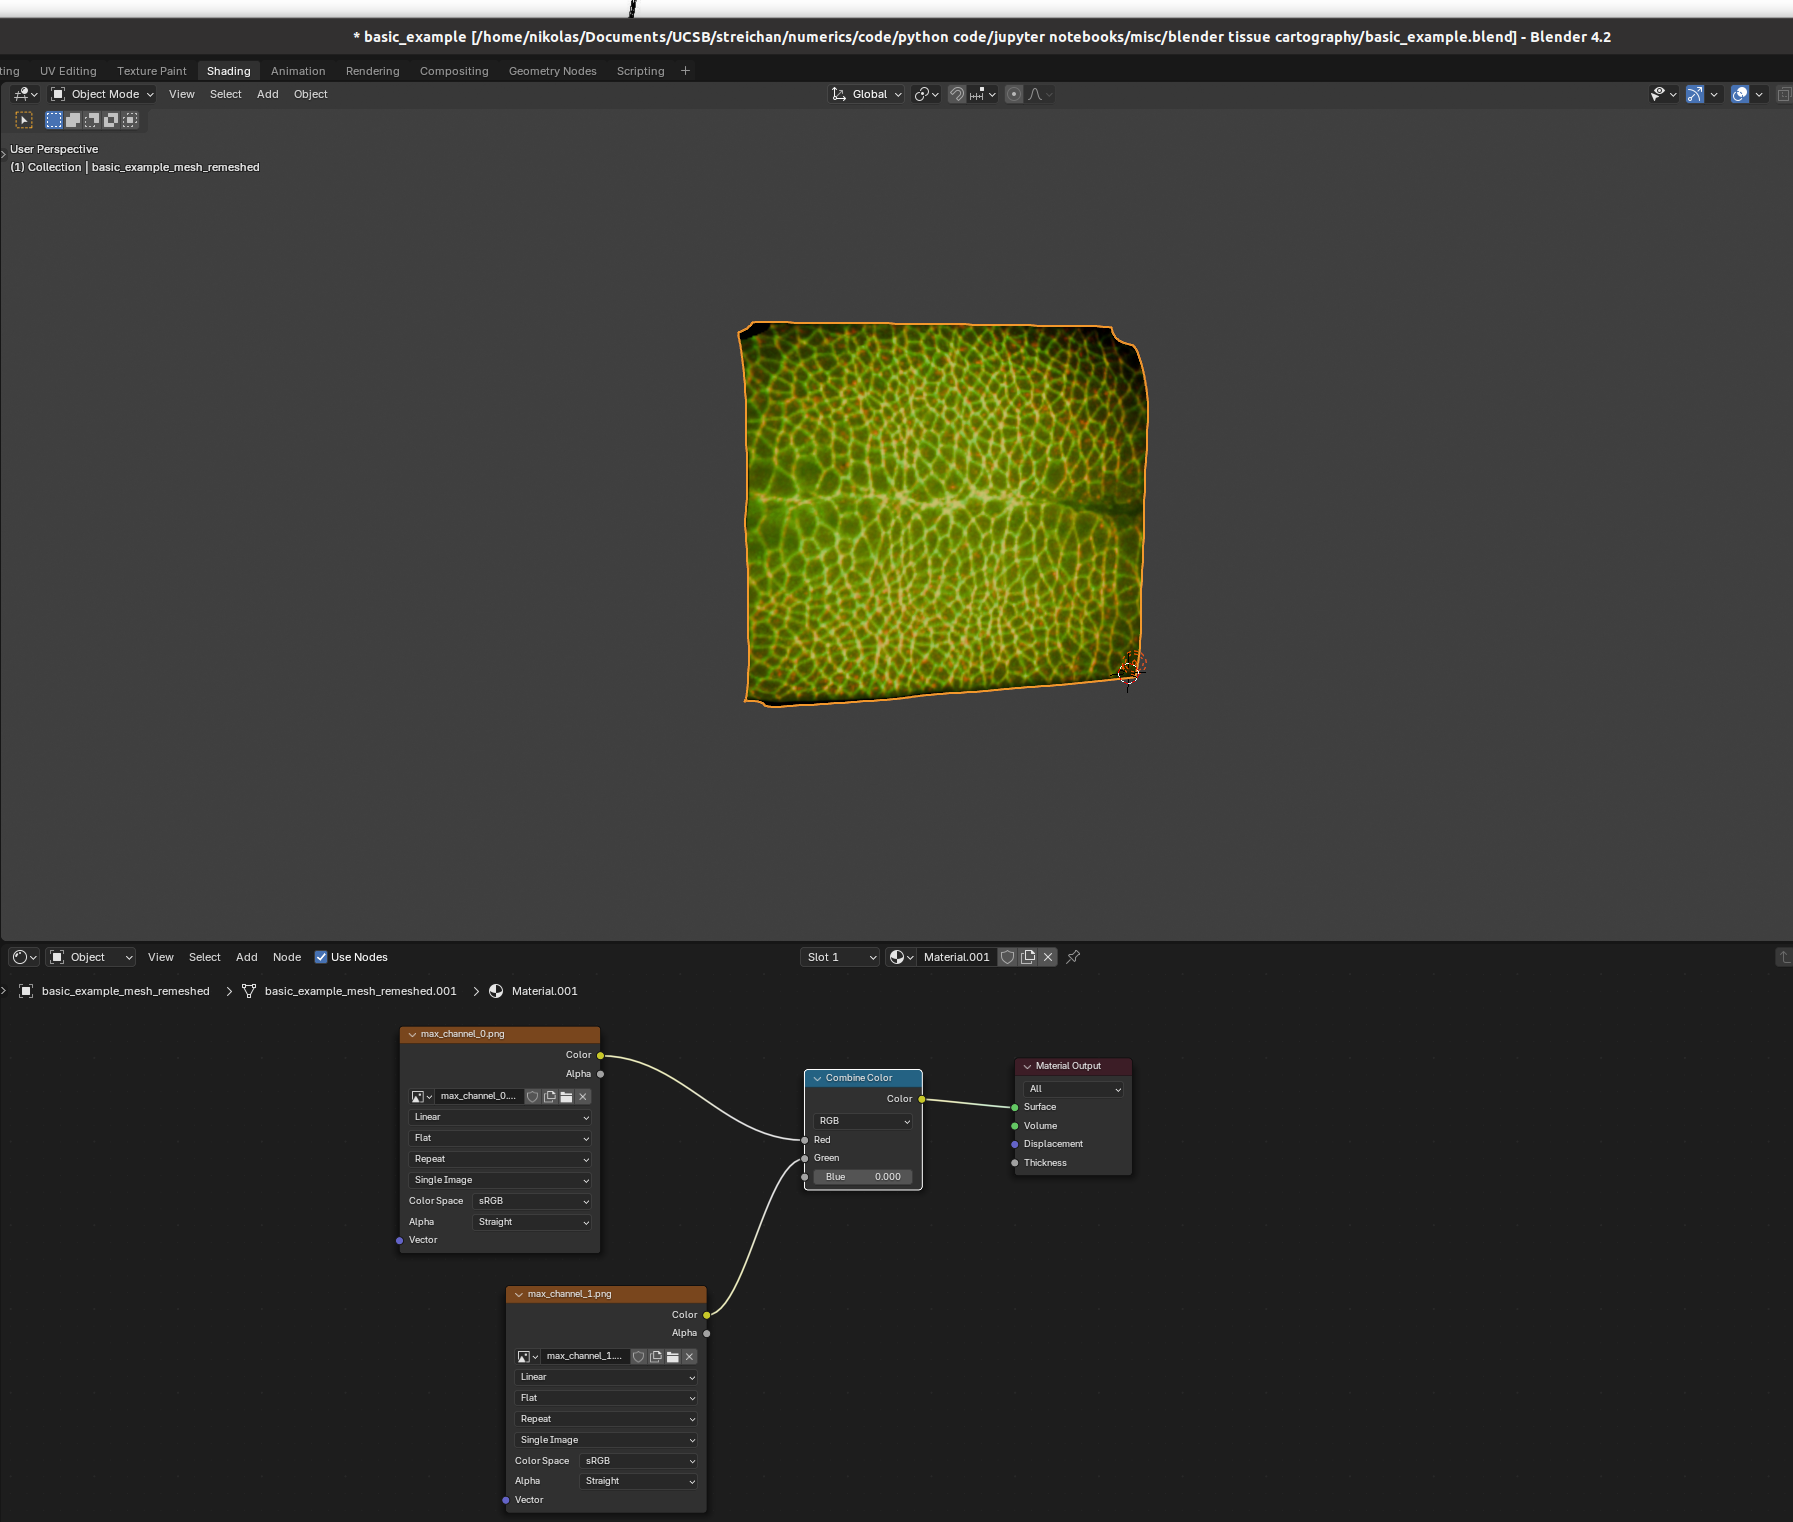

And there we go! Many further options exist to make more sophisticated renderings.

### Next steps

In the next tutorial, we will see how to UV map a more complicated shape (not topologically a disk) via seams.